The purpose of this notebook is to model the decoherence of a qubit. We use a rotationally invariant linear product of spins in the Pauli matrix representation as the interaction Hamiltonian. The expectation is that time evolution under such a Hamiltonian will result in entanglement between the qubit and its environment, yielding a reduced mixed-state density matrix recognized by non-zero eigenvalues.

N > 1: The qubit is entangled with a multi-qubit environment. 

v4: wrap simulation in function and call large number of times (100-1000) to calculate aggregate stats e.g. histograms of mean magnitude of off-diagonal reduced density matrix, histogram of eigenvalues of reduced density matrix

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import itertools

In [2]:
# helper functions
def create_env_basis_list(N):
    """
    Create 2^N different basis states from 0, 1

    Arguments:
    - N: The number of elements in the string to create.

    Returns:
    - perms: List of 2^N strings '0100...'
    """

    perms = list(itertools.product('01', repeat=N))
    
    return perms

def create_ham_order_list(N):
    """
    Create different permutations from 0, 1 for Hamiltonian

    Arguments:
    - N: The number of elements in the string to create.

    Returns:
    - perms: List of strings '0100...'
    """

    perms = list(itertools.permutations('0'*(N-1)+'1'))
    
    return perms

def run_quantum_sim(dt, num_steps, N, ham, q_global):
    """
    Runs the quantum sim and produces reduced density matrix

    Arguments:
    - dt: The timestep for solver.
    - num_steps: The number of timesteps over which to iterate.
    - N: The number of environmental qubits.
    - ham: The global Hamiltonian matrix.
    - q_global: The global quantum state (at the start of the sim and will be updated).

    Returns:
    - eigs_list: list of eigenvalues of the reduced density matrix across sim time 
    - rho_red_od_ll: list of 10 reduced density matrix elements across sim time
    - rho_red_od_ur: list of 01 reduced density matrix elements across sim time
    - rho_red_od_lr: list of 11 reduced density matrix elements across sim time
    - rho_red_od_ul: list of 00 reduced density matrix elements across sim time
    """
        
    # time evolve the global state d|psi> = -i*H|psi>dt

    # record the eigenvalues of the reduced density matrix
    eigs_list = []
    eigvects_list = []
    rho_red_od_ll = []
    rho_red_od_ur = []
    rho_red_od_lr = []
    rho_red_od_ul = []

    for step in range(num_steps):
        q_update = -i*dt*np.dot(ham, q_global)
        heun_term = np.linalg.inv(np.identity(ham.shape[0]) + .5*i*dt*ham) # trying 2nd order solver
        q_global = np.matmul(heun_term, (q_global + q_update*.5))
        q_global_norm = np.sqrt(np.dot(q_global.conj().T, q_global))
        q_global = q_global/(q_global_norm) # need to explicitly normalize since linearization is non-unitary at 2nd order
    
        # form the density matrix of the time-evolved global state
        rho_global = np.outer(q_global, q_global.conj().T)
    
        # trace out the environmental state
        # environmental basis states in global hilbert space
        list_of_env_basis_states = create_env_basis_list(N)
        rho_red = 0
        for perm in list_of_env_basis_states:
            env_basis_state = id_mat
            for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in trace
                if j == '1':
                    env_basis_state = np.kron(up, env_basis_state)
                elif j == '0':
                    env_basis_state = np.kron(down, env_basis_state)
            rho_red = np.matmul(env_basis_state.conj().T, np.matmul(rho_global, env_basis_state)) + rho_red
    
        # calculate the eigenvalues of the reduced density matrix
        eigs = np.linalg.eigvals(rho_red)
        eigs_list.append(eigs)
    
        # calculate the eigenvectors of the reduced density matrix
        w, eigvects = np.linalg.eig(rho_red)
        eigvects_list.append(eigvects)
    
        # store the off-diagonal terms of the reduced density matrix
        rho_red_od_ll.append(np.linalg.norm(rho_red[1,0]))
        rho_red_od_ur.append(np.linalg.norm(rho_red[0,1]))
    
        # store the off-diagonal terms of the reduced density matrix
        rho_red_od_lr.append(np.linalg.norm(rho_red[1,1]))
        rho_red_od_ul.append(np.linalg.norm(rho_red[0,0]))
        
    return eigs_list, rho_red_od_ll, rho_red_od_ur, rho_red_od_lr, rho_red_od_ul

In [3]:
# define the qubit (our system)
up = np.array([1,0]).reshape(2,1)
down = np.array([0,1]).reshape(2,1)
    
c1 = np.sqrt(.5)
c2 = np.sqrt(.5)
qubit = np.array([c1, c2]) # c1|0> + c2|1>
qubit = qubit.reshape(2,1) # reshape as a 2x1 column vector

In [4]:
# define the environment (let's try N>1 now)
N = 7 # number of environmental qubits

q_env = up # get the ball rolling 
for n in range(N-1):
    #if np.round(np.random.rand()) == 0:
    q_env = np.kron(up, q_env)
    #else:
    #    q_env = np.kron(up, q_env)

In [5]:
# define the interaction Hamiltonian between qubit and evironment (linear product of spins)
# pauli matrices
i = complex(0,1)
id_mat = np.array([[1,0],[0,1]])
sigma_x = np.array([[0, 1], [1,0]])
sigma_y = np.array([[0, -i], [i,0]])
sigma_z = np.array([[1, 0], [0,-1]])

ham = 0
coupling = 100 # coupling strength between environment and qubit
'''
list_of_ham_orders = create_ham_order_list(N)
for perm in list_of_ham_orders:
    ham_x = sigma_x
    ham_y = sigma_y
    ham_z = sigma_z
    for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in sum
        if j == '1':
            ham_x = np.kron(sigma_x, ham_x)
            ham_y = np.kron(sigma_y, ham_y)
            ham_z = np.kron(sigma_z, ham_z)
        elif j == '0':
            ham_x = np.kron(id_mat, ham_x)
            ham_y = np.kron(id_mat, ham_y)
            ham_z = np.kron(id_mat, ham_z)
    ham = ham + coupling*(ham_x + ham_y + ham_z)
'''

"\nlist_of_ham_orders = create_ham_order_list(N)\nfor perm in list_of_ham_orders:\n    ham_x = sigma_x\n    ham_y = sigma_y\n    ham_z = sigma_z\n    for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in sum\n        if j == '1':\n            ham_x = np.kron(sigma_x, ham_x)\n            ham_y = np.kron(sigma_y, ham_y)\n            ham_z = np.kron(sigma_z, ham_z)\n        elif j == '0':\n            ham_x = np.kron(id_mat, ham_x)\n            ham_y = np.kron(id_mat, ham_y)\n            ham_z = np.kron(id_mat, ham_z)\n    ham = ham + coupling*(ham_x + ham_y + ham_z)\n"

In [6]:
# define the global combined state of qubit and environment
q_global = np.kron(q_env, qubit)

In [7]:
# time evolve the global state d|psi> = -i*H|psi>dt
dt = .1
num_steps = 5000 #50000

# run the sim and return the reduced density matrix elements + eigenvalues
num_sims = 10
all_eigs = []
all_rho_red_od_ll = []
all_rho_red_od_ur = []
all_rho_red_od_lr = []
all_rho_red_od_ul = []

for sim_count in range(num_sims):
    # trying arbitrary hermitian matrices as the hamiltonian
    ham = coupling*np.random.rand(2**(N+1), 2**(N+1)) + i*(np.random.rand(2**(N+1), 2**(N+1)))
    ham = (ham + ham.conj().T)/2
    eigs_list, rho_red_od_ll, rho_red_od_ur, rho_red_od_lr, rho_red_od_ul\
    = run_quantum_sim(dt, num_steps, N, ham, q_global)
    all_eigs.append(np.mean(eigs_list,0))
    all_rho_red_od_ll.append(np.mean(rho_red_od_ll))
    all_rho_red_od_ur.append(np.mean(rho_red_od_ur))
    all_rho_red_od_lr.append(np.mean(rho_red_od_lr))
    all_rho_red_od_ul.append(np.mean(rho_red_od_ul))

In [8]:
# prep arrays for plotting
eigs_arr = np.array(eigs_list)
eig1 = np.real(np.min(eigs_arr, 1))
eig2 = np.real(np.max(eigs_arr, 1))
t_arr = np.arange(0,dt*num_steps,dt)

smooth_window = 100 # units of dt
eig1_smooth = pd.Series(eig1).rolling(smooth_window, min_periods=1).mean()
eig2_smooth = pd.Series(eig2).rolling(smooth_window, min_periods=1).mean()
rho_red_od_ll_smooth = pd.Series(rho_red_od_ll).rolling(smooth_window, min_periods=1).mean()
rho_red_od_ur_smooth = pd.Series(rho_red_od_ur).rolling(smooth_window, min_periods=1).mean()
rho_red_od_lr_smooth = pd.Series(rho_red_od_lr).rolling(smooth_window, min_periods=1).mean()
rho_red_od_ul_smooth = pd.Series(rho_red_od_ul).rolling(smooth_window, min_periods=1).mean()

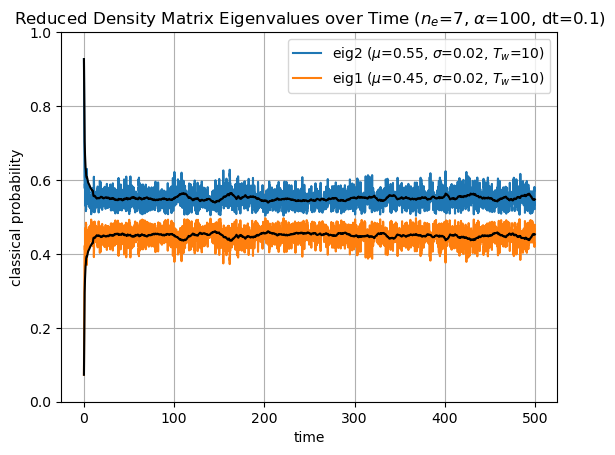

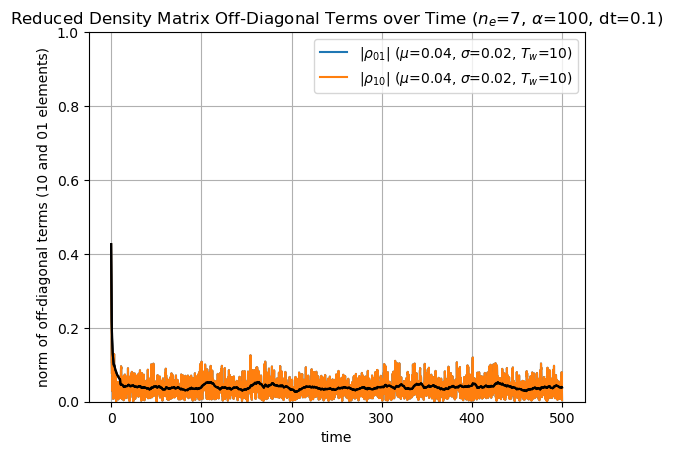

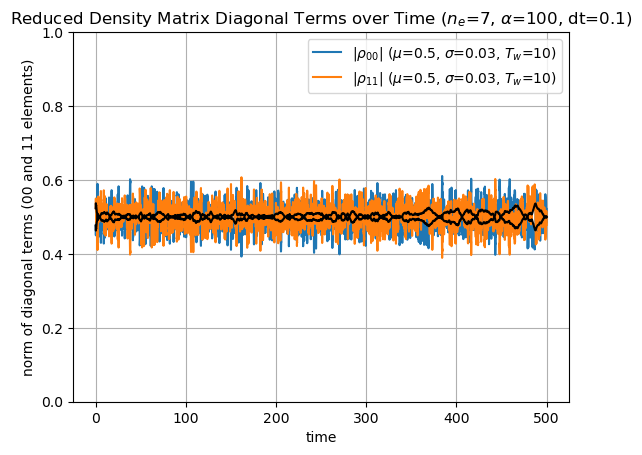

In [9]:
# plot the eigenvalues as a function of time
plt.figure()
plt.subplot()
plt.plot(t_arr, eig2,  label='eig2 ($\mu$='+str(np.round(np.mean(eig2),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(eig2),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, eig1, label='eig1 ($\mu$='+str(np.round(np.mean(eig1),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(eig1),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, eig1_smooth, color='black')
plt.plot(t_arr, eig2_smooth, color='black')
plt.grid()
plt.xlabel('time')
plt.ylabel('classical probability')
plt.title('Reduced Density Matrix Eigenvalues over Time ($n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.ylim([0,1])
plt.legend()

plt.figure()
plt.subplot()
plt.plot(t_arr, rho_red_od_ur, label=r'$|\rho_{01}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_ll),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_ll),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_ll, label=r'$|\rho_{10}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_ll),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_ll),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_ll_smooth, color='black')
plt.plot(t_arr, rho_red_od_ur_smooth, color='black')
plt.grid()
plt.xlabel('time')
plt.ylabel('norm of off-diagonal terms (10 and 01 elements)')
plt.title('Reduced Density Matrix Off-Diagonal Terms over Time ($n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.ylim([0,1])
plt.legend()

plt.figure()
plt.subplot()
plt.plot(t_arr, rho_red_od_ul, label=r'$|\rho_{00}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_ul),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_ul),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_lr, label=r'$|\rho_{11}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_lr),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_lr),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_ul_smooth, color='black')
plt.plot(t_arr, rho_red_od_lr_smooth, color='black')
plt.grid()
plt.xlabel('time')
plt.ylabel('norm of diagonal terms (00 and 11 elements)')
plt.title('Reduced Density Matrix Diagonal Terms over Time ($n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.ylim([0,1])
plt.legend()

C:\Users\rohit\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


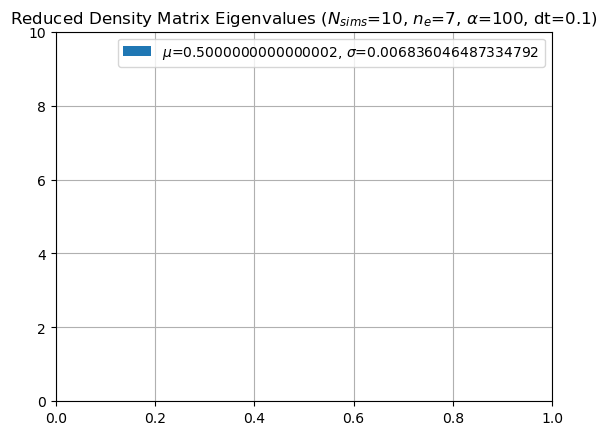

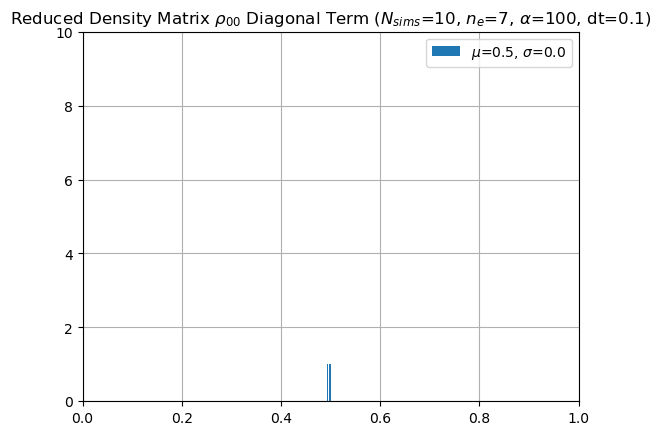

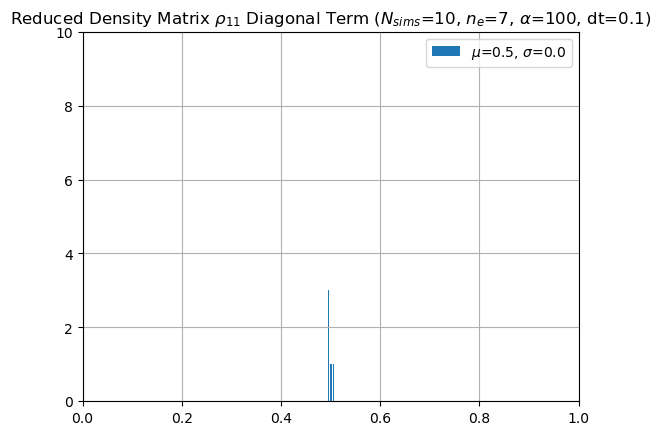

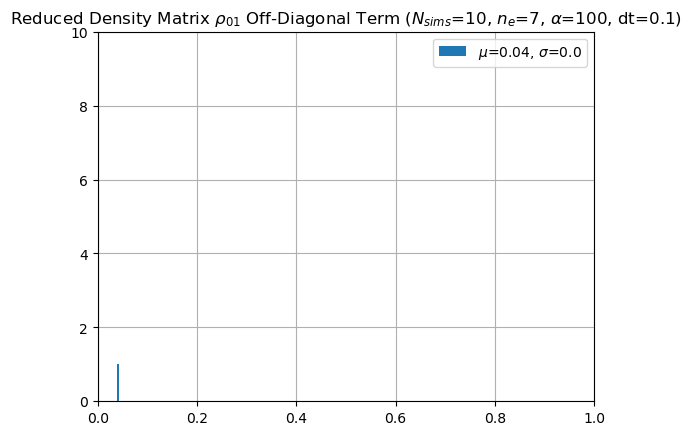

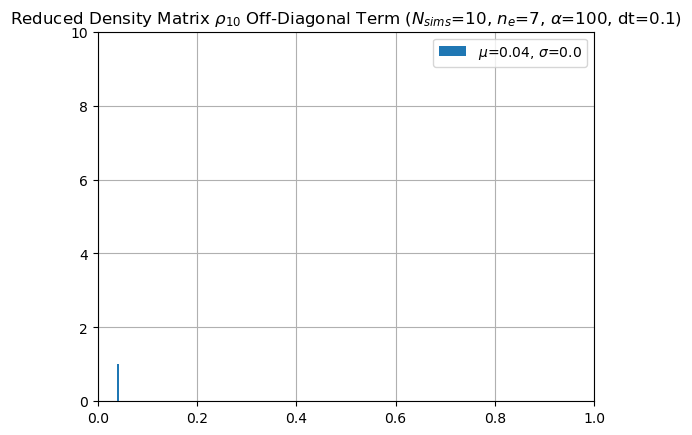

In [10]:
# plot the histograms
# histogram of eigenvalues
plt.figure()
plt.hist(all_eigs, label=r'$\mu$='+str(np.mean(np.real(all_eigs)))+r', $\sigma$='+str(np.std(all_eigs)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title('Reduced Density Matrix Eigenvalues ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# histogram of rho_00
plt.figure()
plt.hist(all_rho_red_od_ul, label=r'$\mu$='+str(np.round(np.mean(all_rho_red_od_ul),2))+\
         r', $\sigma$='+str(np.round(np.std(all_rho_red_od_ul),2)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title(r'Reduced Density Matrix $\rho_{00}$ Diagonal Term ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# histogram of rho_11
plt.figure()
plt.hist(all_rho_red_od_lr, label=r'$\mu$='+str(np.round(np.mean(all_rho_red_od_lr),2))+\
         r', $\sigma$='+str(np.round(np.std(all_rho_red_od_lr),2)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title(r'Reduced Density Matrix $\rho_{11}$ Diagonal Term ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# histogram of rho_01
plt.figure()
plt.hist(all_rho_red_od_ur, label=r'$\mu$='+str(np.round(np.mean(all_rho_red_od_ur),2))+\
         r', $\sigma$='+str(np.round(np.std(all_rho_red_od_ur),2)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title(r'Reduced Density Matrix $\rho_{01}$ Off-Diagonal Term ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# histogram of rho_10
plt.figure()
plt.hist(all_rho_red_od_ll, label=r'$\mu$='+str(np.round(np.mean(all_rho_red_od_ll),2))+\
         r', $\sigma$='+str(np.round(np.std(all_rho_red_od_ll),2)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title(r'Reduced Density Matrix $\rho_{10}$ Off-Diagonal Term ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# Scratch Work

In [11]:
all_rho_red_od_ul

[0.5047810746047602,
 0.49240061971761334,
 0.49994352321093866,
 0.49824895504778816,
 0.4964904248024,
 0.4937871003704471,
 0.5047193241694049,
 0.49736582418626657,
 0.5053277566931496,
 0.5002376428875898]

In [12]:
all_rho_red_od_lr, np.std(all_rho_red_od_lr)

([0.4952189253952399,
  0.5075993802823867,
  0.5000564767890614,
  0.5017510449522119,
  0.5035095751976001,
  0.5062128996295531,
  0.49528067583059526,
  0.5026341758137336,
  0.4946722433068505,
  0.49976235711241024],
 0.004333153817455185)

In [13]:
all_rho_red_od_ll

[0.04156728349695987,
 0.03949586509531818,
 0.040502114675742745,
 0.03903661207475407,
 0.03974289935988124,
 0.03946705028108351,
 0.03997701853401563,
 0.03894909911418178,
 0.039860484765761456,
 0.03951538455865457]

In [14]:
all_rho_red_od_ur

[0.04156728349695987,
 0.03949586509531818,
 0.040502114675742745,
 0.03903661207475407,
 0.03974289935988124,
 0.03946705028108351,
 0.03997701853401563,
 0.03894909911418178,
 0.039860484765761456,
 0.03951538455865457]

In [15]:
str(np.mean(all_eigs))

'(0.5000000000000002+3.8480096930040894e-20j)'

In [16]:
all_eigs

[array([0.50804747-6.65147377e-21j, 0.49195253-1.80395085e-19j]),
 array([0.48855982+1.39046278e-19j, 0.51144018+8.55977021e-20j]),
 array([0.49945391+4.65482159e-20j, 0.50054609+5.26237568e-20j]),
 array([0.497477+1.21619915e-19j, 0.502523+2.40010298e-19j]),
 array([0.49543288-1.33914453e-20j, 0.50456712-3.11475800e-20j]),
 array([0.49071328+1.68873920e-20j, 0.50928672+2.08019507e-19j]),
 array([0.50870148+5.52475146e-20j, 0.49129852-1.13924536e-19j]),
 array([0.49634113+1.23713538e-20j, 0.50365887-1.50845655e-19j]),
 array([0.50829392-2.44894810e-20j, 0.49170608+1.05774101e-22j]),
 array([0.50013422+1.58507613e-20j, 0.49986578+2.96518727e-19j])]